### Load libraries, set pyannote constants for an easy life

In [47]:
from pyannote.audio.labeling.extraction import SequenceLabeling
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
# speech activity detection model trained on AMI training set
SAD_MODEL = ('../models/speech_activity_detection/train/'
             'AMI.SpeakerDiarization.MixHeadset.train/weights/0280.pt')
# speaker change detection model trained on AMI training set
SCD_MODEL = ('../models/speaker_change_detection/train/'
             'AMI.SpeakerDiarization.MixHeadset.train/weights/0870.pt')
# speaker embedding model trained on VoxCeleb1
EMB_MODEL = ('../models/speaker_embedding/train/'               
             'VoxCeleb.SpeakerVerification.VoxCeleb1.train/weights/2000.pt')
sad = SequenceLabeling(model=SAD_MODEL,device=torch.device('cuda'))
scd = SequenceLabeling(model=SCD_MODEL,device=torch.device('cuda'))

C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\pyBK\lib\site-packages\pyannote\audio\applications\base.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.config_ = yaml.load(fp)


### Pre-define our filename for SAD

In [8]:
# one can use their own file like this...
test_file = {'uri': 'filename', 'audio': '../data/raw/z-c-feisty.wav'}

### Initialize SAD & SCD sequence labeling models

# Speech activity detection
Obtain raw SAD scores (as `pyannote.core.SlidingWindowFeature` instance)

In [57]:
sad_scores = sad(test_file)
# binarize raw SAD scores (as `pyannote.core.Timeline` instance)
# NOTE: both onset/offset values were tuned on AMI dataset.
# you might need to use different values for better results.
from pyannote.audio.signal import Binarize
binarize = Binarize(offset=0.7, onset=0.70, log_scale=True)
speech = binarize.apply(sad_scores, dimension=1)
# iterate over speech segments (as `pyannote.core.Segment` instances)
print(len(speech))
for segment in speech:
    print(segment.start, segment.end)

51
0.07 3.8599999999999994
4.38 4.42
4.65 4.69
4.7 4.72
4.75 8.73
9.870000000000001 9.880000000000003
9.89 9.990000000000002
10.0 17.06
17.43 23.34
23.490000000000002 23.54
23.6 23.68
24.0 32.06
32.36999999999999 48.67999999999999
48.95 50.0
50.11 57.09
57.78 63.0
64.04 82.0
82.71000000000001 86.9
86.99 91.51
91.62 93.5
94.24 113.61
114.5 116.5
117.0 128.03000000000003
128.06 140.73000000000002
140.96000000000004 145.36
145.75 148.42000000000002
148.49 148.5
149.31 151.44
152.09000000000003 161.51
161.65000000000003 181.87
182.86 187.72000000000003
187.99 194.0
194.88 211.0
212.19 224.0
224.02000000000004 224.06
226.0 226.86
228.52000000000004 239.5
241.14000000000004 245.0
245.66000000000003 250.44
250.49 250.5
252.0 253.5
254.0 255.5
255.51000000000005 255.65000000000003
256.32 261.0
261.61 283.5
284.71 286.48
286.49 286.5
286.69 292.21
292.42 316.82
316.94 334.95
337.0 337.34000000000003


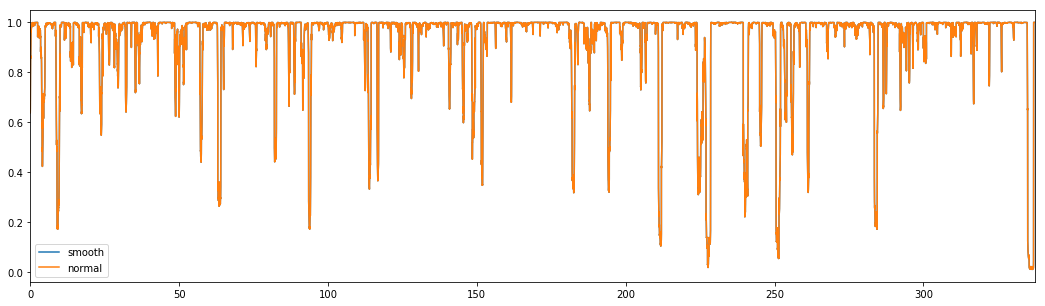

In [58]:
#plt.plot(np.exp(sad_scores.data[:,1]))
from pyannote.core import SlidingWindowFeature

sad_scores_smooth= SlidingWindowFeature(np.exp(sad_scores.data[:, 1:]), sad_scores.sliding_window)
df = pd.DataFrame({'smooth':sad_scores_smooth.data.reshape((-1,)),'normal':np.exp(sad_scores.data[:,1])},
                  index = np.arange(sad_scores.data.shape[0])*sad_scores.sliding_window.step)
df.plot(figsize = (18,5))

In [44]:

#??sad_scores.sliding_window.segmentToRange

33700.0

# Speaker change detection

36
-0.0125 16.65
16.65 18.03
18.03 28.36
28.36 34.05
34.05 41.239999999999995
41.239999999999995 42.91
42.91 45.58
45.58 46.489999999999995
46.489999999999995 73.8
73.8 100.39
100.39 116.0
116.0 116.49000000000001
116.49000000000001 117.8
117.8 125.79
125.79 152.14000000000004
152.14000000000004 162.29000000000002
162.29000000000002 166.73000000000002
166.73000000000002 178.5
178.5 190.16000000000003
190.16000000000003 236.5
236.5 236.99
236.99 250.89000000000004
250.89000000000004 253.33000000000004
253.33000000000004 255.04000000000002
255.04000000000002 256.31
256.31 258.5
258.5 296.55
296.55 297.49
297.49 298.32
298.32 299.14
299.14 304.71
304.71 309.65000000000003
309.65000000000003 313.0
313.0 316.15000000000003
316.15000000000003 334.93
334.93 337.3625


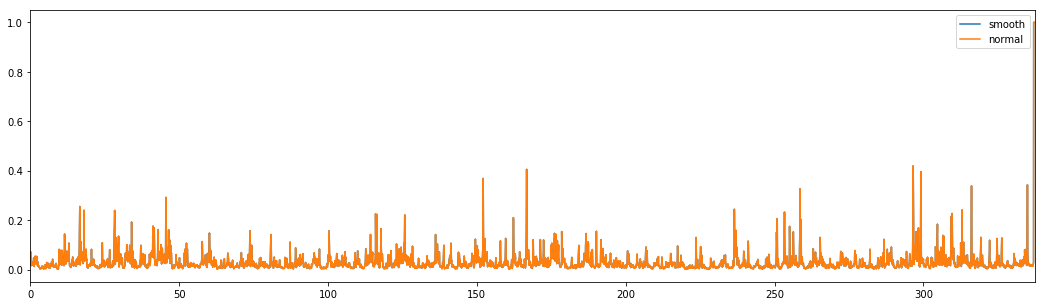

In [59]:
# obtain raw SCD scores (as `pyannote.core.SlidingWindowFeature` instance)
scd_scores = scd(test_file)
# detect peaks and return speaker homogeneous segments 
# (as `pyannote.core.Annotation` instance)
# NOTE: both alpha/min_duration values were tuned on AMI dataset.
# you might need to use different values for better results.
from pyannote.audio.signal import Peak
peak = Peak(alpha=0.15, min_duration=0.40, log_scale=True)
partition = peak.apply(scd_scores, dimension=1)
print(len(partition))
for segment in partition:
    print(segment.start, segment.end)
scd_scores_smooth= SlidingWindowFeature(np.exp(scd_scores.data[:, 1:]), scd_scores.sliding_window)
df = pd.DataFrame({'smooth':scd_scores_smooth.data.reshape((-1,)),'normal':np.exp(scd_scores.data[:,1])},
                  index = np.arange(scd_scores.data.shape[0])*scd_scores.sliding_window.step)
df.plot(figsize = (18,5));

# Final segmentation ( an overlay of SAD and SCD)

In [60]:
# speech turns are simply the intersection of SAD and SCD
speech_turns = partition.crop(speech)

Visualize the results

Text(0.4875, 0.1, 'speech turns')

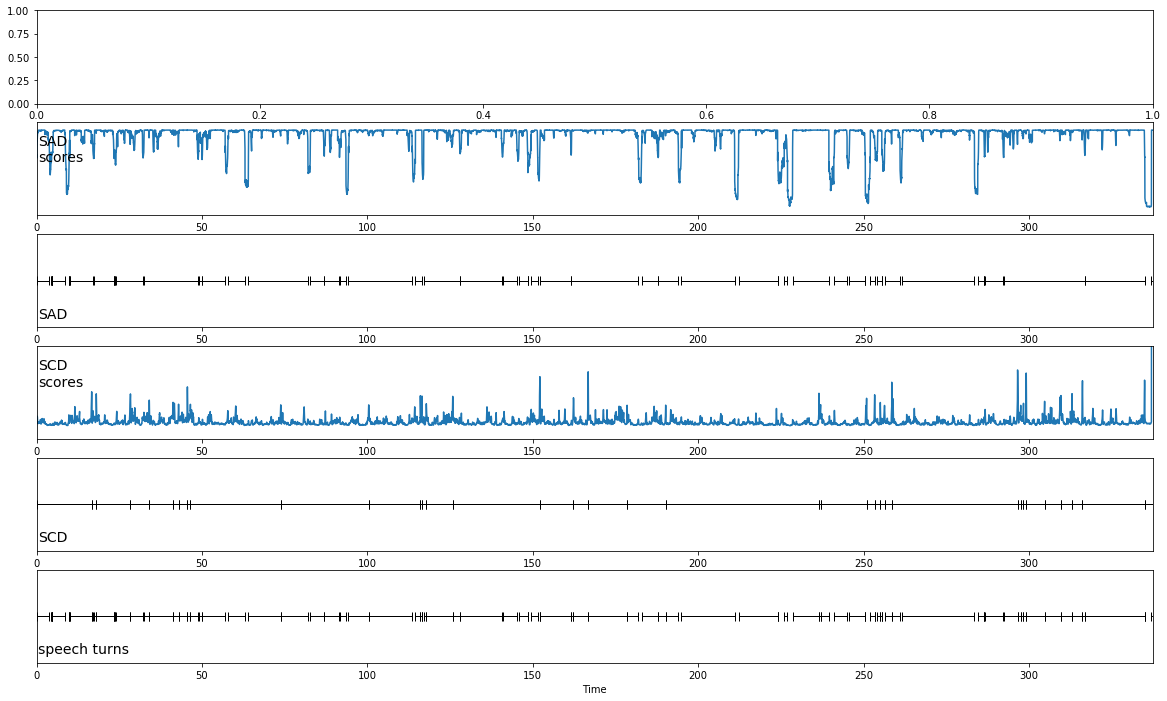

In [61]:
# let's visualize SAD and SCD results using pyannote.core visualization API
from pyannote.core import Segment, notebook

# only plot one minute (between t=120s and t=180s)
#notebook.crop = Segment(120, 180)

# helper function to make visualization prettier
from pyannote.core import SlidingWindowFeature
plot_ready = lambda scores: SlidingWindowFeature(np.exp(scores.data[:, 1:]), scores.sliding_window)

# create a figure with 6 rows with matplotlib
nrows = 6
fig, ax = plt.subplots(nrows=nrows, ncols=1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 2)

# 2nd row: SAD raw scores
notebook.plot_feature(plot_ready(sad_scores), ax=ax[1])
ax[1].text(notebook.crop.start + 0.5, 0.6, 'SAD\nscores', fontsize=14)
ax[1].set_ylim(-0.1, 1.1)

# 3rd row: SAD result
notebook.plot_timeline(speech, ax=ax[2])
ax[2].text(notebook.crop.start + 0.5, 0.1, 'SAD', fontsize=14)

# 4th row: SCD raw scores
notebook.plot_feature(plot_ready(scd_scores), ax=ax[3])
ax[3].text(notebook.crop.start + 0.5, 0.3, 'SCD\nscores', fontsize=14)
ax[3].set_ylim(-0.1, 0.6)

# 5th row: SCD result
notebook.plot_timeline(partition, ax=ax[4])
ax[4].text(notebook.crop.start + 0.5, 0.1, 'SCD', fontsize=14)

# 6th row: combination of SAD and SCD
notebook.plot_timeline(speech_turns, ax=ax[5])
ax[5].text(notebook.crop.start + 0.5, 0.1, 'speech turns', fontsize=14)